# Installing required libraries

In [ ]:
!pip install bitarray transformers evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 6.5 MB/s eta 0:00:00


# Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch
from transformers import (
    GPT2Tokenizer,
    DataCollatorForLanguageModeling,
    TextDataset,
    GPT2LMHeadModel,
    TrainingArguments,
    Trainer)

# Preparing training dataset (Image COCO captions and EMNLP news)

In [ ]:
!git clone https://github.com/weilinie/RelGAN.git
!cat RelGAN/data/image_coco.txt RelGAN/data/emnlp_news.txt > training_data.txt
train_path = 'training_data.txt'

Cloning into 'RelGAN'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 121 (delta 41), reused 31 (delta 31), pack-reused 64
Receiving objects: 100% (121/121), 15.77 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (65/65), done.


# Fine-tuning GPT2-medium on the datasets

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_path,
    block_size=128)

In [ ]:
print(tokenizer.decode(train_dataset[5]))

. 
office space with office equipment on desk top.
two husky's hanging out of the car windows.
the back door with a window in the kitchen.
jet liner flying off into the distance on an overcast day
a cat eating a bird it has caught.
a woman is walking a dog in the city.
cars try to maneuver into parking spaces along a densely packed city street. 
dogs stick their heads out of car windows
a person sits on a patch of grass observing the scenery.
a tiny bathroom with only a toilet and a shelf.
a little girl in a public bathroom for


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
training_args = TrainingArguments(
    output_dir = 'drive/MyDrive/gpt2_checkpoints', # the output directory for the model predictions and checkpoints
    overwrite_output_dir = True, # overwrite the content of the output directory
    per_device_train_batch_size = 16, # the batch size for training
    learning_rate = 1e-6,
    num_train_epochs = 1, # total number of training epochs to perform
)

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator=data_collator,
    train_dataset = train_dataset,
)

In [ ]:
# takes about 4 hours on a normal Colab GPU
trainer.train()

In [ ]:
model.save_pretrained("drive/MyDrive/our_gpt2")
tokenizer.save_pretrained("drive/MyDrive/our_gpt2")

('drive/MyDrive/our_gpt2/tokenizer_config.json',
 'drive/MyDrive/our_gpt2/special_tokens_map.json',
 'drive/MyDrive/our_gpt2/vocab.json',
 'drive/MyDrive/our_gpt2/merges.txt',
 'drive/MyDrive/our_gpt2/added_tokens.json')

# Creating a dummy secret_message file to showcase our method

In [ ]:
!echo -n "This is a secret message!" > secret_message

# Utility classes for model loading and encoding/decoding

In [ ]:
# REQUIRES DRIVE TO BE MOUNTED!
model_name = "drive/MyDrive/our_gpt2"

In [ ]:
class GPT2:
    """A wrapper for the GPT2 language model from hugging-face transformers.
    """
    def __init__(self, model_name, device="auto"):
        self._model_name = model_name
        # load tokenizer and language model head
        self._tokenizer = GPT2Tokenizer.from_pretrained(self._model_name)
        self._lm = GPT2LMHeadModel.from_pretrained(self._model_name)
        # put model on GPU if available for faster inference
        if device=="auto":
            self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self._device = device
    
    def __repr__(self):
        return self._model_name
    
    def tokenize(self, input):
        """Returns a list of sub-word tokens given a string of text.
        """
        tokens = [self._tokenizer.decode(i) for i in self._tokenizer.encode(input)]
        # 'My dog is cute.' -> ['my', ' dog', ' is', ' cute', '.']
        return tokens
    
    def predict_top_k(self, ctx, k, seed=0):
        """Predict the next subword given context.
        """
        # set seed for reproducability of results
        torch.manual_seed(seed)

        # convert tokens to indexes
        token_idxs = torch.tensor([self._tokenizer.encode(ctx)])
        # set model to eval mode to disable dropout layers
        self._lm.eval()
        # send model and tokens to device (GPU VRAM if available or CPU RAM)
        token_idxs = token_idxs.to(self._device)
        self._lm.to(self._device)

        # calculate prediction
        with torch.no_grad():
          outputs = self._lm(token_idxs)[0]

        # unnormalized probabilities
        logits = outputs[0, -1, :]
        
        # return top k most probable next tokens with <|endoftext|> token removed.
        rankings =  [self._tokenizer.decode(i.item()) for i in logits.topk(k+1)[1]]
        if "<|endoftext|>" in rankings:
            rankings.remove("<|endoftext|>")
        return rankings


In [ ]:
lm = GPT2(model_name)

In [ ]:
from bitarray import bitarray
from string import punctuation

class Codec():
    """A simple encoder-decoder utility to show a proof of concept for 
    linguistic steganography.
    """
    def __init__(self, message=None, lm=None, begin_phrase="Hello", k=2):
        if isinstance(message, bitarray) or message is None:
            self._message = message
        elif isinstance(message, str):
            self._message = bitarray()
            with open(message, 'rb') as fh:
                self._message.fromfile(fh)
        else:
            ValueError('Expected bitarray or filepath.')
        self._chunk_size = k
        self._message_length = None
        if self._message is not None:
            self._message_length = len(self._message)
        if self._message_length % self._chunk_size != 0:
            ValueError(f'Please select a k such that message length ({self._message_length}) is divisible by it. (currently k={self._chunk_size})')
        if lm is None:
            ValueError('Please specify a language model object.')
        self._lm = lm
        # require a sample space of 2^k for k-bit chunks of the original message
        self._top_k = 2**k
        self._begin_phrase = begin_phrase
    
    def encode(self, out_path):
        """Encode file in text in self._chunk_size'd chunks.
        """
        if self._message is None:
            ValueError('This instance of the codec was not initialized with a message.')
        # divide the message into chunks of size 'k'
        chunks = [self._message[i:i+self._chunk_size] for i in range(0, self._message_length - self._chunk_size + 1, self._chunk_size)]
        # start with the begin phrase (default: 'Hello')
        enc_text = self._begin_phrase
        # begin encoding, skipping punctuation for a higher quality text grammatically
        pos = 0
        while pos < len(chunks):
            # preds is already sorted
            preds = self._lm.predict_top_k(enc_text, self._top_k)
            # skip if punctuation
            if preds[0] in punctuation or preds[0].isspace():
                enc_text += preds[0]
                continue
            # instead of choosing the highest probably 'preds', choose the value
            # represented by the current chunk of data to embed the chunk within
            # the word.
            chunk_to_decimal = int(chunks[pos].to01(), base=2)
            enc_text += preds[chunk_to_decimal]
            pos += 1
        
        # if the encoded text doesn't end with an <eos>, pad it until an <eos>
        # to make the text more coherent. NOTE: the padding does not contain any
        # message, it is just there to make the text more believable.
        while not enc_text.endswith('.'):
            preds = self._lm.predict_top_k(enc_text, 1)
            enc_text += preds[0]

        # write enc_text to file    
        with open(out_path, 'w') as fh:
            fh.write(enc_text)
        return enc_text

    def decode(self, in_path, out_path, message_length=None):
        """Decode file from text. 
        """
        if message_length is None and self._message_length is None:
            ValueError('Message length not provided.')
        if message_length is not None:
            self._message_length = message_length
        # read encoded file
        with open(in_path, 'r') as fh:
            enc_text = fh.read()
        bits = bitarray()
        # tokenize the encoded file
        splits = self._lm.tokenize(enc_text)
        # the first word is the begin phrase, extract it as context for the LM
        context = splits[0]
        splits = splits[1:]
        # begin decoding
        for i in range(len(splits)):
            preds = self._lm.predict_top_k(context, self._top_k)
            context += splits[i]
            # skip if punctuation
            if preds[0] in punctuation or preds[0].isspace():
                continue
            try:
                chunk = preds.index(splits[i])
            except:
                pass
            bits.extend(bin(chunk)[2:].zfill(self._chunk_size))
            # if reached the end of message, discard the rest of the text
            # because it's just padding.
            if len(bits) == self._message_length:
                break
        # write decoded text to file
        with open(out_path, 'wb') as fh:
            bits.tofile(fh)
        return bits

# Experiment

In [ ]:
# initialize codec with GPT-2 and begin_phrase="Moreover" and k=2
# secret_message is exactly 200 bits
c = Codec('secret_message', lm, begin_phrase='Moreover', k=2)

In [ ]:
# encode secret_message within text
encoded = c.encode('secret.enc')
print(encoded)

Moreover, it's important to remember, this is just the tip.


For example, in the above example, the user has the ability of setting the background color, but the background is not visible. In the above example, if a user is viewing an app with the same background image, but different background image, then it will not work.


If the user is not using the app, the application is still able, and will continue to display that same background, even when the background image has been updated.


In addition, the app can use the same background image for different screen sizes.


In [ ]:
# decode encoded text
decoded = c.decode('secret.enc', 'secret.dec')

In [ ]:
# check that original message is equal to the decoded message
assert c._message == decoded

# Perplexity Experiments

In [ ]:
from matplotlib import pyplot as plt
import evaluate
perplexity = evaluate.load("perplexity", module_type="metric")
k_vals = [1, 2, 4, 5, 8]
starting_words = ['The', 'There', 'Hello', 'This', 'He', 'Moreover', 'It']
ppls = []
for k in k_vals:
    input_texts = []
    for starting_word in starting_words:
        c = Codec('secret_message', lm, k=k, begin_phrase='The')
        encoded = c.encode('secret.enc')
        input_texts.append(encoded)
    # compare perplexity with the original gpt2-medium
    # as a representative of the natural language
    results = perplexity.compute(model_id="gpt2-medium",
                                add_start_token=False,
                                predictions=input_texts)
    ppls.append(results["mean_perplexity"])

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ppls

[4.9166451181684225,
 9.565113067626953,
 24.114858627319336,
 70.64942932128906,
 77.72686767578125]

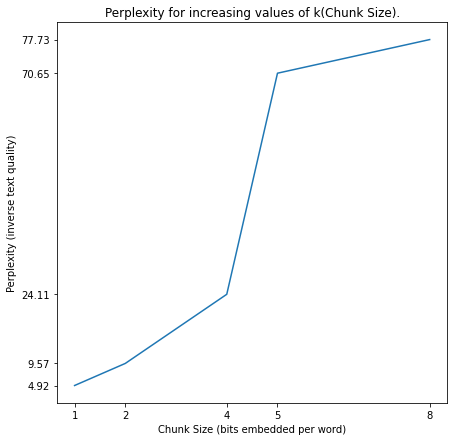

In [ ]:
plt.figure(figsize=(7, 7))
plt.title("Perplexity for increasing values of k(Chunk Size).")
plt.xlabel("Chunk Size (bits embedded per word)")
plt.ylabel("Perplexity (inverse text quality)")
plt.xticks(k_vals)
plt.yticks(ppls)
plt.plot(k_vals, ppls)
plt.show()

In [ ]:
k_vals_lstm = [1, 2, 3, 4, 5]
# perplexities taken from Table 3 in their results
attn_lstm_ppls = [6.3555, 9.136, 12.002, 19.48075, 27.59275]

k_vals_tstega = [1, 2, 3, 4]
# perplexities taken from Table 1 in their results
gan_tstega_ppls = [18.5, 102.9, 344.8, 851.65]

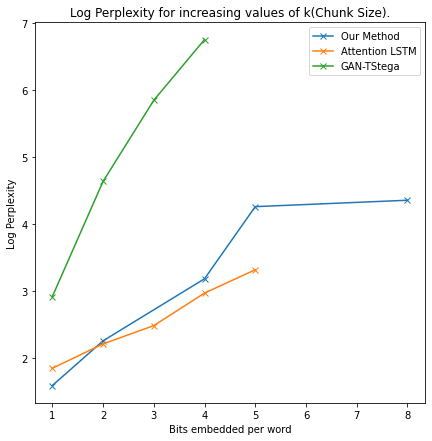

In [ ]:
import numpy as np
plt.figure(figsize=(7, 7))
plt.title("Log Perplexity for increasing values of k(Chunk Size).")
plt.xlabel("Bits embedded per word")
plt.ylabel("Log Perplexity")
plt.plot(k_vals, np.log(ppls), label="Our Method", marker='x')
plt.plot(k_vals_lstm, np.log(attn_lstm_ppls), label="Attention LSTM", marker='x')
plt.plot(k_vals_tstega, np.log(gan_tstega_ppls), label="GAN-TStega", marker='x')
plt.legend()
plt.show()